### 데이터 리사이즈

In [ ]:
import os


images = os.listdir("pokemon")

for i, name in enumerate(images):
    png = Image.open("pokemon/" + name)
    png.load()
    
    background = Image.new("RGB", png.size, (0, 0, 0))
    background.paste(png, mask=png.split()[3]) # 3 is the alpha channel
    
    background.thumbnail((32, 32), Image.ANTIALIAS)
    background.save("pokemon_rgb/" + str(i) + ".jpg", "JPEG", quality=80)
    

### class PokemonData: 데이터 준비

In [3]:
import os.path
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import keras.backend as K
import matplotlib.pyplot as plt
from PIL import Image

K.set_image_data_format('channels_last')

class PokemonData():
    def __init__(self):
        img_data_list = []
        images = os.listdir('pokemon_rgb')
        
        for path in images:
            img = Image.open('pokemon_rgb/' + path)
            img_data_list.append([np.array(img).astype('float32')])
        
        self.x_train = np.vstack(img_data_list) / 255.0
        print(self.x_train.shape)

### class Gan: 모델 설계

In [4]:
class Gan:
    def __init__(self, img_data):
        img_size = img_data.shape[1]
        channel = img_data.shape[3] if len(img_data.shape) >=4 else 1
        
        self.img_data = img_data
        self.input_shape = (img_size, img_size, channel)
        
        self.img_rows = img_size
        self.img_cols = img_size
        self.channel = channel
        self.noise_size = 100
        
        # Create D and G
        self.create_d()
        self.create_g()
        
        # Build model to train D
        optimizer = Adam(lr=0.0008)
        self.D.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        # Build model to train G
        optimizer = Adam(lr=0.0004)
        self.D.trainable = False
        self.AM = Sequential()
        self.AM.add(self.G)
        self.AM.add(self.D)
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def create_d(self):
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=self.input_shape, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D
    
    def create_g(self):
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 8
        self.G.add(Dense(dim*dim*depth, input_dim=self.noise_size))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Conv2DTranspose(self.channel, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G
    
    def train(self, batch_size=100):
        # Pick image data randomly
        images_train = self.img_data[np.random.randint(0, self.img_data.shape[0], size=batch_size), :, :, :]
        
        # Generate imgaes from noise
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size])
        images_fake = self.G.predict(noise)
        
        # Train D
        x = np.concatenate((images_train, images_fake))
        y = np.ones([2*batch_size, 1])
        y[batch_size:, :] = 0
        self.D.trainable = True
        d_loss = self.D.train_on_batch(x, y)
        
        # Train G
        y = np.ones([batch_size, 1])
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size])
        self.D.trainable = False
        a_loss = self.AM.train_on_batch(noise, y)
        
        return d_loss, a_loss, images_fake
    
    def save(self):
        self.G.save_weights('gan_g_weights.h5')
        self.D.save_weights('gan_d_weights.h5')
        
    def load(self):
        if os.path.isfile('gan_g_weights.h5'):
            self.G.load_weights('gan_g_weights.h5')
            print("Load G from file")
        if os.path.isfile('gan_d_weights.h5'):
            self.D.load_weights('gan_g_weights.h5')
            print('Load D from file')

### 모델 학습 및 이미지 생성

(819, 32, 32, 3)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4

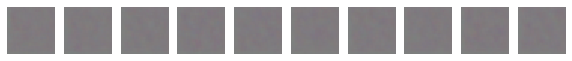

Epoch: 20, D Loss: 0.4462769627571106, AM Loss: 6.694916754961014


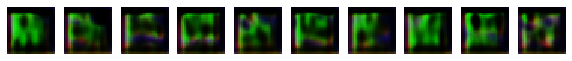

Epoch: 40, D Loss: 0.18281598202884197, AM Loss: 1.251688502728939


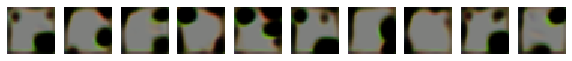

Epoch: 60, D Loss: 0.14920826721936464, AM Loss: 2.980119466781616


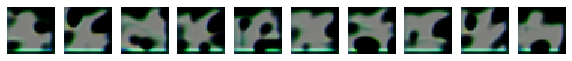

Epoch: 80, D Loss: 0.15003161132335663, AM Loss: 3.203236013650894


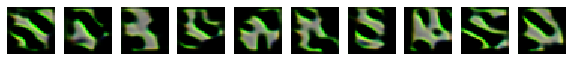

Epoch: 100, D Loss: 0.2009674794971943, AM Loss: 3.1520646810531616


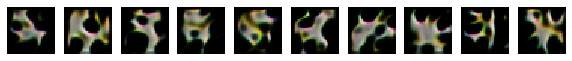

Epoch: 120, D Loss: 0.17486376501619816, AM Loss: 2.416751280426979


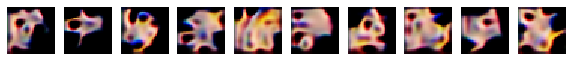

Epoch: 140, D Loss: 0.18825620133429766, AM Loss: 2.0594461411237717


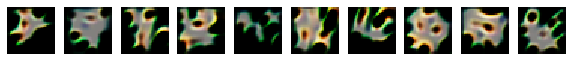

Epoch: 160, D Loss: 0.1733429003506899, AM Loss: 4.025226414203644


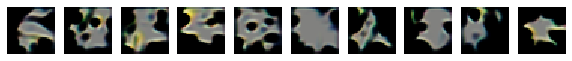

Epoch: 180, D Loss: 0.23784498125314713, AM Loss: 2.61094306409359


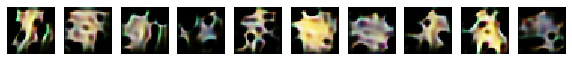

Epoch: 200, D Loss: 0.44085828587412834, AM Loss: 1.5361603647470474


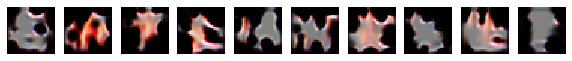

Epoch: 220, D Loss: 0.3480013832449913, AM Loss: 2.909632235765457


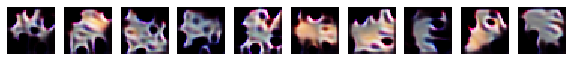

Epoch: 240, D Loss: 0.21493141259998083, AM Loss: 3.7393903136253357


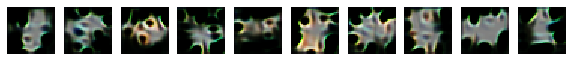

Epoch: 260, D Loss: 0.4478294476866722, AM Loss: 2.2776198387145996


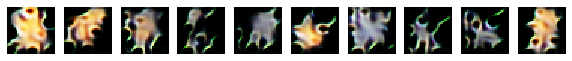

Epoch: 280, D Loss: 0.2523354385048151, AM Loss: 4.116759330034256


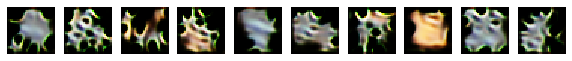

Epoch: 300, D Loss: 1.009636789560318, AM Loss: 1.1464443653821945


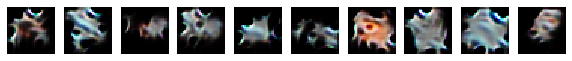

Epoch: 320, D Loss: 0.41554998978972435, AM Loss: 2.313094452023506


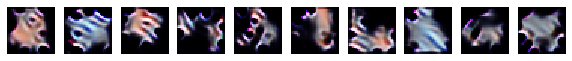

Epoch: 340, D Loss: 0.570844266563654, AM Loss: 2.7173520922660828


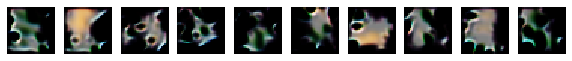

Epoch: 360, D Loss: 0.277893359772861, AM Loss: 4.296074450016022


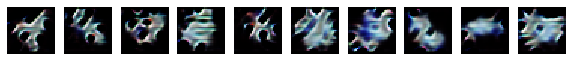

Epoch: 380, D Loss: 0.2426056731492281, AM Loss: 3.2356167435646057


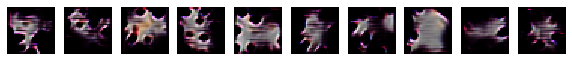

Epoch: 400, D Loss: 0.24355933256447315, AM Loss: 3.1876294165849686


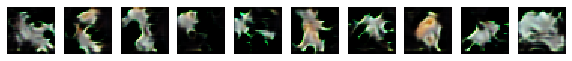

Epoch: 420, D Loss: 0.32088519632816315, AM Loss: 2.3954008370637894


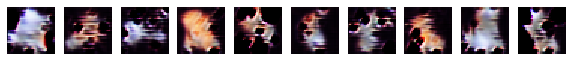

Epoch: 440, D Loss: 0.24188790656626225, AM Loss: 2.9391370117664337


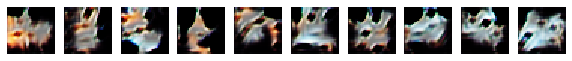

Epoch: 460, D Loss: 0.14860505145043135, AM Loss: 4.212961256504059


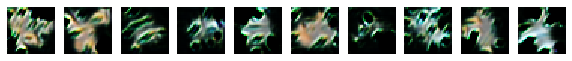

Epoch: 480, D Loss: 0.2112791445106268, AM Loss: 4.039534240961075


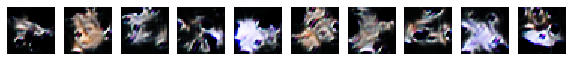

Epoch: 500, D Loss: 0.299470454454422, AM Loss: 3.529371455311775


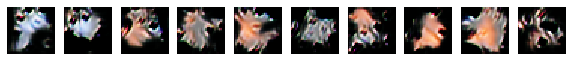

Epoch: 520, D Loss: 0.23291726782917976, AM Loss: 2.977737069129944


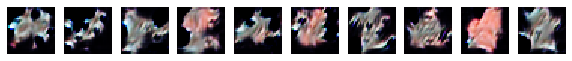

Epoch: 540, D Loss: 0.2139181699603796, AM Loss: 4.174725592136383


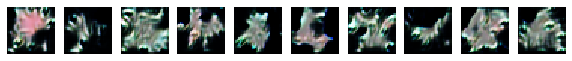

Epoch: 560, D Loss: 0.3476329669356346, AM Loss: 2.8343705236911774


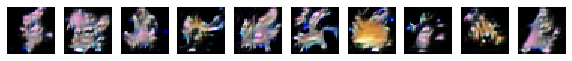

Epoch: 580, D Loss: 0.3027020040899515, AM Loss: 3.4434897899627686


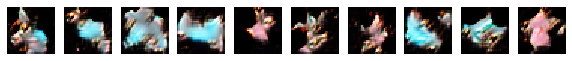

Epoch: 600, D Loss: 0.15178101509809494, AM Loss: 6.104249477386475


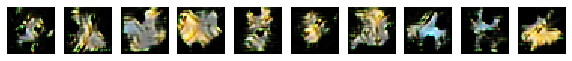

Epoch: 620, D Loss: 0.14049740508198738, AM Loss: 3.987410932779312


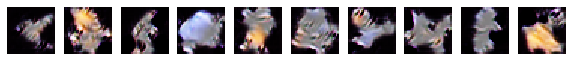

Epoch: 640, D Loss: 0.18359883967787027, AM Loss: 4.8798481822013855


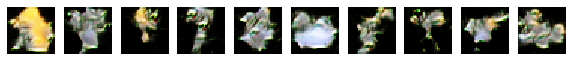

Epoch: 660, D Loss: 0.15938253700733185, AM Loss: 3.522229701280594


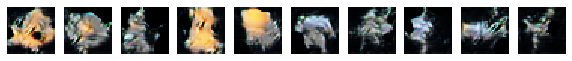

Epoch: 680, D Loss: 0.2142460122704506, AM Loss: 4.048652023077011


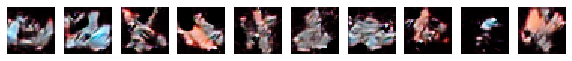

Epoch: 700, D Loss: 0.29927757754921913, AM Loss: 3.3605538606643677


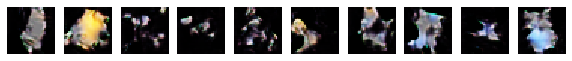

Epoch: 720, D Loss: 0.18901393562555313, AM Loss: 4.239641040563583


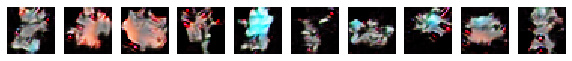

Epoch: 740, D Loss: 0.2832897622138262, AM Loss: 4.223025441169739


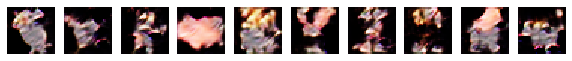

Epoch: 760, D Loss: 0.08168137213215232, AM Loss: 5.815367758274078


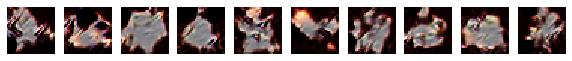

Epoch: 780, D Loss: 0.13933695293962955, AM Loss: 4.743788301944733


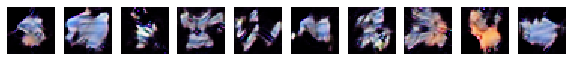

Epoch: 800, D Loss: 0.1551784025505185, AM Loss: 4.787454515695572


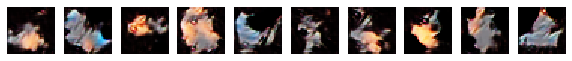

Epoch: 820, D Loss: 0.21873503550887108, AM Loss: 4.6716627180576324


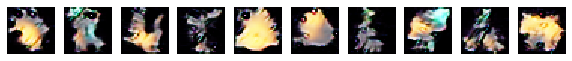

Epoch: 840, D Loss: 0.17937368899583817, AM Loss: 4.4956870675086975


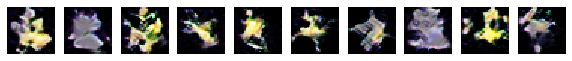

Epoch: 860, D Loss: 0.13301787059754133, AM Loss: 4.930849879980087


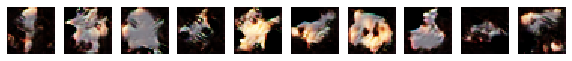

Epoch: 880, D Loss: 0.19161580130457878, AM Loss: 4.259956002235413


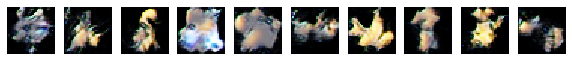

Epoch: 900, D Loss: 0.16496428940445185, AM Loss: 6.136645078659058


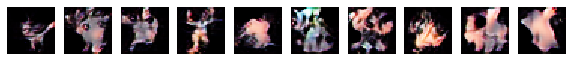

Epoch: 920, D Loss: 0.12891532108187675, AM Loss: 5.5239577293396


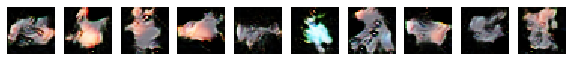

Epoch: 940, D Loss: 0.1341023724526167, AM Loss: 5.879905343055725


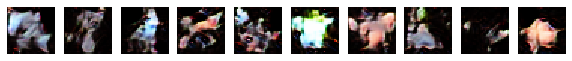

Epoch: 960, D Loss: 0.11137072741985321, AM Loss: 6.3004602789878845


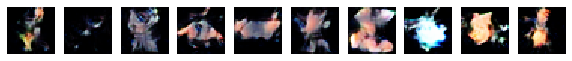

Epoch: 980, D Loss: 0.11858145147562027, AM Loss: 5.720293939113617


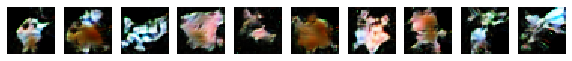

Epoch: 999, D Loss: 0.14654594752937555, AM Loss: 6.2132720947265625


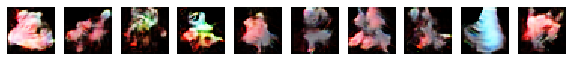

In [5]:
# Load dataset
dataset = PokemonData()
x_train = dataset.x_train

# Init network
gan = Gan(x_train)
gan.load()

# Some parameters
epochs = 1000
sample_size = 10
batch_size = 100
train_per_epoch = x_train.shape[0] // batch_size

for epoch in range(0, epochs):
    total_d_loss = 0.0
    total_a_loss = 0.0
    imgs = None
    
    for batch in range(0, train_per_epoch):
        d_loss, a_loss, t_imgs = gan.train(batch_size)
        total_d_loss += d_loss
        total_a_loss += a_loss
        if imgs is None:
            imgs = t_imgs
    
    if epoch % 20 == 0 or epoch == epochs -1:
        total_d_loss /= train_per_epoch
        total_a_loss /= train_per_epoch
        
        print("Epoch: {}, D Loss: {}, AM Loss: {}".format(epoch, total_d_loss, total_a_loss))

        # Show generated images
        fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))
        for i in range(0, sample_size):
            ax[i].set_axis_off()
            ax[i].imshow(imgs[i].reshape((gan.img_rows, gan.img_cols, gan.channel)),
                        interpolation='nearest');
        
        plt.show()
        plt.close(fig);
        
        # Save weights
        gan.save()